In [1]:
#external imports
from pickle import FALSE, TRUE
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split    
from torchvision import transforms
from torch.utils.data import DataLoader
import math
from torch import nn
import timm
import matplotlib.pyplot as plt
#import neptune.new as neptune
from skopt import BayesSearchCV
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer
from GPUtil import showUtilization as gpu_usage
import gc
gc.collect()
import os
#internal imports
from dataset import PTB_Dataset
from train import train_loop
from model import My_Network, My_Network2
#from predict import predict
from validation import validation_loop
from utils import accuracy_fn
import warnings
warnings.filterwarnings('ignore')
#constants
from constants import REC_PATH,CSV_PATH,DATASET_LIMIT,BATCH_SIZE,N_LEADS,N_CLASSES,NEPOCHS

torch.cuda.empty_cache()

c:\Users\tomo9\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

#main function
def main(weights_name,epochs=50,batch_size=64,lr = 1e-4,momentum=0.9,weight_decay=0.5):
    CustomDataset = PTB_Dataset(CSV_PATH,REC_PATH,transforms.ToTensor())
    print(CustomDataset.__len__())
    
    #Train %
    TRAIN_SIZE = math.floor(CustomDataset.__len__()*0.75)
    #print(CustomDataset.__len__(),TRAIN_SIZE)
    TEST_SIZE = CustomDataset.__len__()-TRAIN_SIZE
    train_dataset,test_dataset = torch.utils.data.random_split(CustomDataset,[TRAIN_SIZE, TEST_SIZE])
    VALID_SIZE = math.floor(TRAIN_SIZE*0.4)
    TRAIN_SIZE = TRAIN_SIZE - VALID_SIZE
    valid_dataset,train_dataset = torch.utils.data.random_split(train_dataset,[VALID_SIZE, TRAIN_SIZE])

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
    valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset,batch_size=batch_size)
    dataloaders = {
        'Train':
            train_dataloader,
        'Valid':
            valid_dataloader,
        'Test':
            test_dataloader
    }
    set_sizes = {
        'Train':TRAIN_SIZE,
        'Valid':VALID_SIZE,
        'Test':TEST_SIZE
    }


    #print(f'test_dataset {test_dataset}')
    model = My_Network(lstm_input_dim = 10,hidden_dim = 10,num_layers = 2)

    #model = My_Network2()
    model=model.to(device)
    loss_fn = nn.MSELoss(reduction='mean')
    #print('a')

    optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=momentum,weight_decay=weight_decay)
    #print(model)
    best_loss=10e10
    best_epoch =10e5
    loss,epoch = train_loop(dataloaders=dataloaders,model=model,loss_fn=loss_fn,optimizer=optimizer,device=device,epochs=epochs,weights_name = weights_name,set_sizes=set_sizes,evaluate=True)
    if loss<best_loss:
        best_loss=loss
        best_epoch=epoch
        best_weights = weights_name
    return best_loss,best_epoch,best_weights



model=My_Network(lstm_input_dim = 10,hidden_dim = 10,num_layers = 2)
nr_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {nr_params}')

Number of parameters: 80911


In [8]:
gpu_usage()
main('test',epochs = 300,batch_size = 32,lr = 1e-4,momentum=0.9,weight_decay=0.5)

| ID | GPU | MEM |
------------------
|  0 |  8% | 32% |
6749
Epoch 1/300
----------
Train phase, loss: 29.214323043823242
Valid phase, loss: 23.75971221923828
Saving model weights as : testpt
Epoch 2/300
----------
Train phase, loss: 15.015615463256836
Valid phase, loss: 18.417837142944336
Saving model weights as : testpt
Epoch 3/300
----------
Train phase, loss: 13.569849014282227
Valid phase, loss: 16.922788619995117
Saving model weights as : testpt
Epoch 4/300
----------
Train phase, loss: 12.839186668395996
Valid phase, loss: 18.080055236816406
Epoch 5/300
----------
Train phase, loss: 11.439414024353027
Valid phase, loss: 15.133060455322266
Saving model weights as : testpt
Epoch 6/300
----------
Train phase, loss: 11.03519344329834
Valid phase, loss: 14.982940673828125
Saving model weights as : testpt
Epoch 7/300
----------
Train phase, loss: 11.058076858520508
Valid phase, loss: 19.479717254638672
Epoch 8/300
----------
Train phase, loss: 10.28738784790039
Valid phase, loss: 18.

(4.588288307189941, 86, 'test')

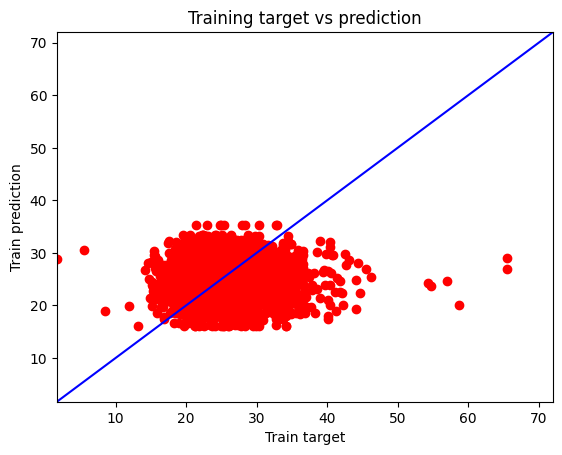

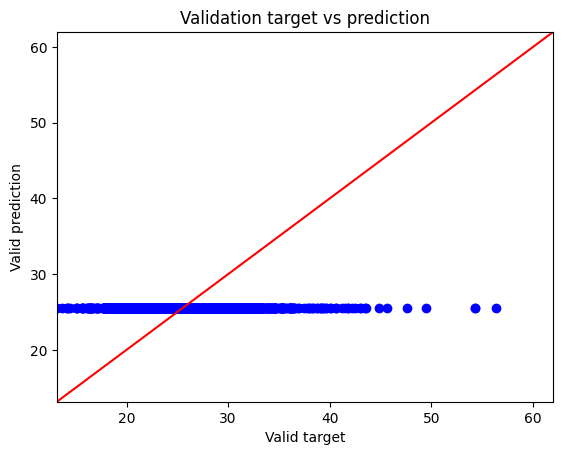

In [27]:
def plot_train(weights,epoch):
    save_path=os.path.join('results/',weights)
    df = pd.read_csv(save_path+'values.csv')
    x = df['Train_target'].iloc[epoch-1]
    x=x.replace('[','')
    x=x.replace(']','')
    
    x_float = [float(s) for s in x.split(',')]
    #print(x_float)
    y = df['Train_pred'].iloc[epoch-1]
    y=y.replace('[','')
    y=y.replace(']','')
    y_float = [float(s) for s in y.split(',')]
    #print(y_float)
    plt1 = plt.figure()
    plt1 = plt.scatter(x_float, y_float,label='Training target vs prediction',color='red')
    plt1 = plt.title('Training target vs prediction')
    plt1 = plt.xlabel('Train target')
    plt1 = plt.ylabel('Train prediction')
    #plt1 = plt.legend()
    #get axis limits
    min_train = min(min(y_float),min(x_float))
    max_train = max(max(y_float),max(x_float))*1.1
    plt1 = plt.xlim(min_train, max_train)
    plt1 = plt.ylim(min_train, max_train)
    lims = [
    min_train,  # min of both axes
    max_train,  # max of both axes
        ]

    # now plot both limits against eachother
    plt1=plt.plot(lims, lims,color='blue')
    #ax.set_aspect('equal')  
    
    

    x = df['Valid_target'].iloc[epoch-1]
    x=x.replace('[','')
    x=x.replace(']','')
    
    x_float = [float(s) for s in x.split(',')]
    #print(x_float)
    y = df['Valid_pred'].iloc[epoch-1]
    y=y.replace('[','')
    y=y.replace(']','')
    y_float = [float(s) for s in y.split(',')]
    #print(y_float)
    plt2 = plt.figure()
    plt2 = plt.scatter(x_float, y_float,label='Validation target vs prediction',color='blue')
    plt2 = plt.xlabel('Valid target')
    plt2 = plt.ylabel('Valid prediction')
    plt2 = plt.title('Validation target vs prediction')
    #plt2 = plt.legend()
    #get axis limits
    min_valid = min(min(y_float),min(x_float))
    max_valid = max(max(y_float),max(x_float))*1.1
    plt2 = plt.xlim(min_valid, max_valid)
    plt2 = plt.ylim(min_valid, max_valid)
    lims = [
        min_valid,  # min of both axes
        max_valid,  # max of both axes
        ]
    # now plot both limits against eachother
    plt2=plt.plot(lims, lims,color='red')
    

    
    plt.savefig(save_path+'valid.png')
    

plot_train('lr0.01_mom0.9decay0.9999',300)

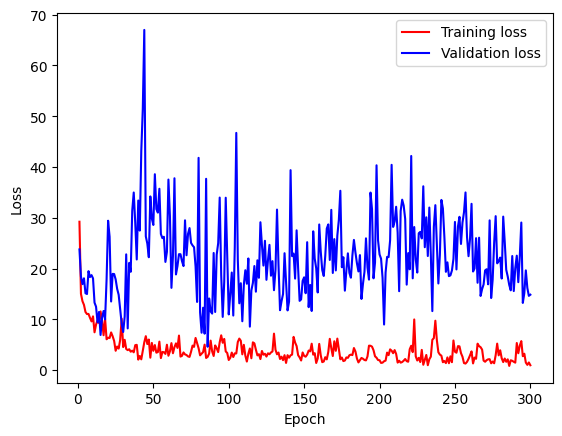

In [24]:
def plot_loss(weights):
    save_path=os.path.join('results/',weights)
    df = pd.read_csv(save_path+'metrics.csv')
    train_loss =df['Train_loss'].iloc[:]
    valid_loss =df['Valid_loss'].iloc[:]
    #print(train_loss)
    x =len(train_loss)
    plt1 = plt.figure()
    plt1=plt.plot(df['epoch'],train_loss,label='Training loss',color='red')
    plt1=plt.plot(df['epoch'],valid_loss,label='Validation loss',color='blue')
    plt1=plt.legend()
    plt1=plt.ylabel('Loss')
    plt1=plt.xlabel('Epoch')
    plt1=plt.savefig(save_path+'loss.png')
plot_loss('lr0.01_mom0.9decay0.9999values')

In [28]:
#learning rate, momentum = 0.9, decay = learning rate / epochs
def hpt(lr_list,momentum_list,epochs,decay_list,decay_hpt = False):
    for lr in lr_list:
        for momentum in momentum_list:
            if decay_hpt == True:
                for decay in decay_list:
                    name = 'lr' + str(lr) +"_" + 'mom' + str(momentum)+'decay'+str(decay)
                    name_pt = name
                    print(name)
                    best_loss = 10e10
                    best_epoch = 10e5
                    out_weights = None
                    out_loss,out_epoch,out_weights=main(weights_name=name_pt,epochs=epochs,batch_size=10,lr=lr,momentum=momentum,weight_decay=decay)
                    if out_loss<best_loss:
                        best_loss=out_loss
                        best_epoch=out_epoch
                        best_weights=out_weights
                        best_decay=decay
                    
                    model = None
                    torch.cuda.empty_cache()
                    gc.collect()
            else:
                decay = decay_list[0]
                name = 'lr' + str(lr) +"_" + 'mom' + str(momentum)+'decay'+str(decay)
                name_pt = name
                print(name)
                best_loss = 10e10
                best_epoch = 10e5
                out_weights = None
                out_loss,out_epoch,out_weights=main(weights_name=name_pt,epochs=epochs,batch_size=10,lr=lr,momentum=momentum,weight_decay=decay)
                if out_loss<best_loss:
                    best_loss=out_loss
                    best_epoch=out_epoch
                    best_weights=out_weights
                    best_decay=decay
                model = None
                torch.cuda.empty_cache()
                gc.collect()
    print('hpt done')
    print(F"best loss: {best_loss}, best epoch: {best_epoch}, best weights: {best_weights}")
    #plot results
    plot_train(best_weights,best_epoch)
    plot_loss(best_weights)
    return best_epoch,best_weights
epochs = 300
lr_list =[1e-4]
momentum_list = [0.7]
decay_list = 0.5

gpu_usage()
final_epoch,final_weights = hpt(lr_list=lr_list,momentum_list=momentum_list,epochs=epochs,decay_list=decay_list)



| ID | GPU | MEM |
------------------
|  0 |  5% | 36% |
lr0.0001_mom0.7decay0.5
6749
Epoch 1/300
----------


KeyboardInterrupt: 

In [ ]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = torch.load('./results/best_model.pt')
model.to(device)

def plot_results(model,dataloader,device,dir):
    pred_history=[]
    true_history=[]
    for batch, (input,target) in enumerate(DataLoader):
        outputs = model(input)
        pred_history = pred_history + outputs.detach().cpu().numpy().tolist()
        true_history = true_history + target.detach().cpu().numpy().tolist()
    
    #visualize things
    print('Used model:')
    print(model)

    #visualize train and valdiaiton loss:
    path='results/a'
    try:
        os.mkdir(path)
    except OSError as error:
        print(error)
    














In [ ]:

os.path.join(save_path,'metrics.csv'

In [ ]:
"""
print("show losses per epochs")
x=range(0,NEPOCHS)
plt.plot(x,train_loss,label='train loss')
plt.plot(x,valid_loss,label='validation loss')
plt.legend(loc='upper right')

plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.title('Train and validation losses vs epochs')
plt.savefig('loss.png')
plt.show()
plt.close()"""

In [ ]:

















"""
print("train_loss_history:")
x=range(0,NEPOCHS)
fig, ax = plt.subplots()
plt.scatter(x,train_loss_history,label='loss')
plt.savefig('loss.png')
plt.show()
plt.close()
print(train_loss_history)
#print(len(train_output_history))
#print(len(train_true_history))

print("last train values")
#x=range(0,len(train_output_history))
plt.scatter(train_true_history,train_output_history,color='blue',label='x:true, y: prediction')
#plt.scatter(x,train_true_history,color='red',label='true')
plt.show()
plt.savefig('train.png')
plt.close()


#x=range(0,TEST_SIZE)
#plot vlaidation data:
plt.scatter(valid_true_history,valid_pred_history,color='blue',label='x:true, y: prediction')
#plt.scatter(x,valid_true_history,color='red',label='true')
plt.legend()
plt.savefig('validation.png')
plt.show()
plt.close()

In [ ]:
#save to file
f = open('valid_results.csv',"w")
f.write('pred;target\n')
for i in range(len(valid_pred_history)):
    #print(str(valid_pred_history[i])+';'+str(valid_true_history[i])+'\n')
    f.write(str(valid_pred_history[i])+";"+str(valid_true_history[i])+"\n")
f.close()
"""

